<a href="https://colab.research.google.com/github/miltondp/k99_courses/blob/main/cis_522/classes/01_31-week3/CIS_522_W3D1_Tutorial_%E2%80%93_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 3 Part 1
# Multi-Layer Perceptrons (MLPs)

__Instructor__: Konrad Kording

__Content creators:__ Arash Ash, Ann-Katrin Reuel

---
# Tutorial objectives
In this tutorial, we delve deeper by using one of the most famous deep learning models of all!

MLPs are arguably one of the most tractable models that we can use to study deep learning fundamentals. Here we will learn why MLPs are: 

* similar to biological networks
* good at function approximation

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'yidih, miltondp' #@param {type:"string"}
my_pod = "Factorial Ferrets"  # @param ["Factorial Ferrets", "Causal Crows", "Recursive Roosters", "Bayesian Bighorns", "Probabilistic Pronghorns", "Hashing Hares", "Multiplicative Mustangs", "Curiosity Capybaras", "Subspace Salamanders"]
my_email = 'yidih@upenn.edu, miltondp@gmail.com' #@param {type:"string"}
tutorial = 'W3D1'


# start timing
import time
try:t0;
except NameError: t0 = time.time()

# Recap the experience from last week

We focused on linear deep learning last week. We discussed Artificial Neural Networks and saw how it works, the dynamics of learning, and the properties of high dimensional spaces. You should now have some intuition about deep learning systems we will learn. We also dived into PyTorch and autograd, which are tools that make our life easy. 

Video available at https://youtube.com/watch?v=xlYttP5C_LY


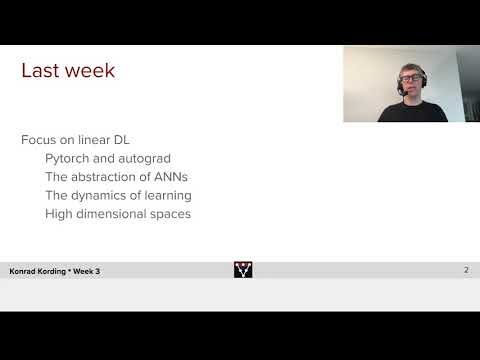

In [ ]:
#@title Video: Discussing Week 2 - Linear DL
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="xlYttP5C_LY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Setup

In [ ]:
# imports
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

# Make sure the Runtime is with TPU to ensure maximum speed
dev = "cpu"

In [ ]:
# @title Seeding for reproducibility
seed = 522
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = seed % (worker_id+1)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# @title Dataset download
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip 

In [ ]:
# @title Figure settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [ ]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))

def plot_function_approximation(x, relu_acts, y_hat):
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel = 'x', ylabel = 'Activation', title = 'ReLU Activations')
  labels = [f'ReLU {i + 1}' for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot function approximation
  axes[1].plot(x, torch.sin(x), label = 'truth')
  axes[1].plot(x, y_hat, label = 'estimated')
  axes[1].legend()
  axes[1].set(xlabel = 'x', ylabel = 'y(x)', title = 'Function Approximation');

  plt.tight_layout()
  plt.show()

---
# Section 1: Neuron Physiology

Video available at https://youtube.com/watch?v=exTzHGfEAvU


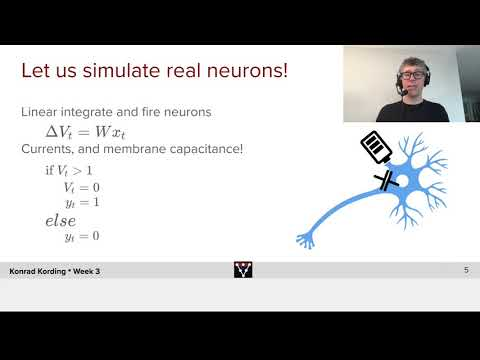

In [ ]:
#@title Video: Overview and Integrate-and-Fire Neurons
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="exTzHGfEAvU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 1.1: Leaky Integrate-and-fire (LIF)
The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The model dynamics is defined with the following formula,

$$
\frac{d V}{d t}=\left\{\begin{array}{cc}
\frac{1}{C}\left(-\frac{V}{R}+I \right) & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
$$

Note that $V$, $C$, and $R$ are the membrane voltage, capacitance, and resitance of the neuron respectively and $-\frac{V}{R}$ is the leakage current. When $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, it momentarily spikes and then $V$ is reset to $V_{\rm reset}< V_{\rm th}$, and voltage stays at $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential (note that $V_{\rm reset}$ and $\tau_{\rm ref}$ is assumed to be zero in the lecture):

\begin{eqnarray}
V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}

where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

Thus, the LIF model captures the facts that a neuron:
- performs spatial and temporal integration of synaptic inputs 
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- has a leaky membrane 


## Exercise 1: Simulating an LIF Neuron

In the cell below is given a function for LIF neuron model with it's arguments described. Now, it's your turn to try this simple mathematical model of a neuron:

Note that we will use Euler's method to make a numerical approximation to a derivative. Hence we will use the following implementation of the model dynamics,

$$
V_n=\left\{\begin{array}{cc}
V_{n-1} + \frac{1}{C}\left(-\frac{V}{R}+I \right) \Delta t & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
$$

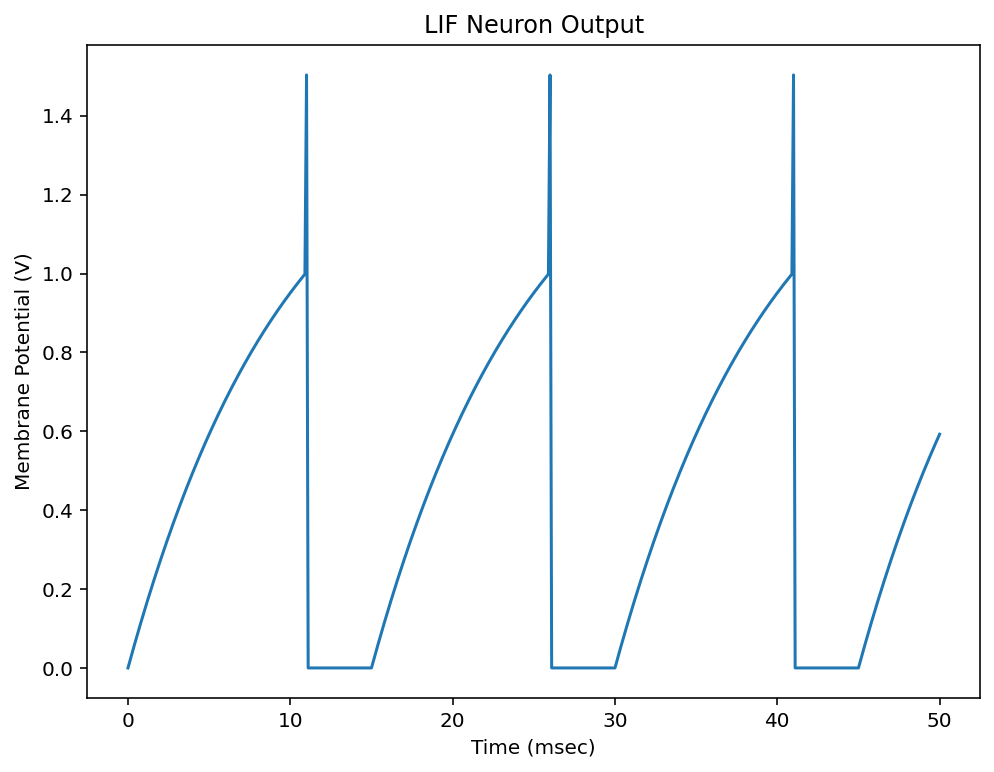

In [ ]:
def run_LIF(I, T = 50, dt = 0.1, t_rest = 0, tau_ref = 4,
            Rm = 1, Cm = 10, Vth = 1, V_spike = 0.5):
  """
  Simulate the LIF dynamics with external input current

  Args:
    I          : input current (mA)
    T          : total time to simulate (msec)
    dt         : simulation time step (msec)
    t_rest     : initial refractory time
    tau_ref    : refractory period (msec)
    Rm         : resistance (kOhm)
    Cm         : capacitance (uF)
    Vth        : spike threshold (V)
    V_spike    : spike delta (V)

  Returns:
    time       : time points
    Vm         : membrane potentials
  """

  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Define the LIF model")
  ####################################################################

  # Set up array of time steps
  time = torch.arange(0, T+dt, dt)
  
  # Set up array for tracking Vm
  Vm = torch.zeros(len(time)) 

  # Iterate over each time step
  for i, t in enumerate(time):

    # If t is after refractory period
    if t > t_rest:
      Vm[i] = Vm[i-1] + 1/Cm * (-Vm[i-1]/Rm + I) * dt

    # If Vm is over the threshold
    if Vm[i] >= Vth:
      
      # Increase volatage by change due to spike
      Vm[i] += V_spike

      # Set up new refactory period
      t_rest = t + tau_ref

  return time, Vm


### Uncomment below to test your function
sim_time, Vm = run_LIF(1.5)

plt.plot(sim_time, Vm)
plt.title('LIF Neuron Output')
plt.ylabel('Membrane Potential (V)')
plt.xlabel('Time (msec)')
plt.show()

## Section 1.2: Nonlinearity of LIF neurons

Video available at https://youtube.com/watch?v=6IzHZB7xf34


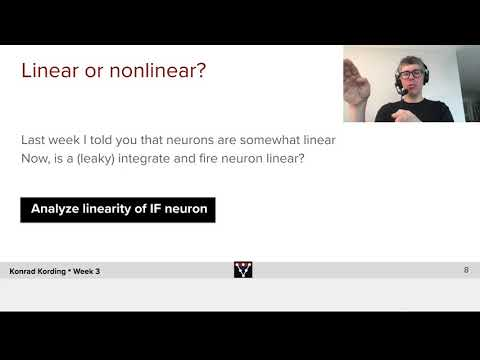

In [ ]:
#@title Video: Are Integrate-and-Fire Neurons Linear?

video = YouTubeVideo(id="6IzHZB7xf34", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Interactive demo: F-I explorer for different $R_m$
We know that neurons communicate by modulating the spike count. Therefore it makes sense to characterize their spike count as a function of input current. This is called the neuron's input-output transfer function (so simply F-I curve). Let's plot the neuron's F-I curve and see how it changes with respect to the membrane resistance? 

In [ ]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

@widgets.interact(Rm=widgets.FloatSlider(1., min=0.5, max=10., step=0.1, layout=my_layout))

def plot_IF_curve(Rm):
  T = 100 # total time to simulate (msec)
  dt = 1 # simulation time step (msec)
  Vth = 1 # spike threshold (V)
  Is = torch.linspace(0, 2, 10)
  spike_counts = []
  for I in Is:
    _, Vm = run_LIF(I, T = T, Vth = Vth, Rm=Rm)
    spike_counts += [torch.sum(Vm > Vth)]

  plt.plot(Is, spike_counts)
  plt.title('LIF Transfer Function (I/F Curve)')
  plt.ylabel('Spike count')
  plt.xlabel('I (mA)')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='Rm', max=10.0, min=0.5), Output()), _dom_classes=('w…

---
# Section 2: The Need for MLPs

Video available at https://youtube.com/watch?v=PERmPT1cOP0


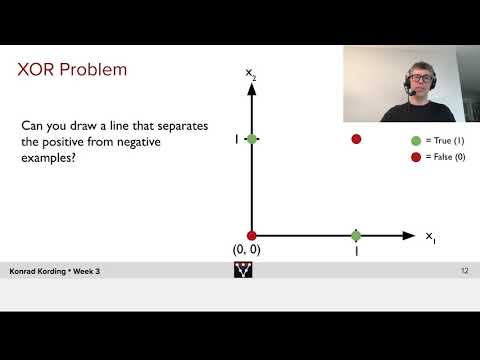

In [ ]:
#@title Video: The XOR Problem

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="PERmPT1cOP0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In the previous tutorial we have illustrated a weird solution to the XOR problems using a linear NN. However, this has happened because of a nonlinear regime in tiny values. Here, we are exposed to a limitation of linear systems, namely in solving the XOR problem. One cannot draw a straight line to separate the positive (1) and negative examples(0). 
The nonlinearity of the multilayer perceptron comes in handy to solve this problem. 
We will visualize this concept next: 

## Exercise 2: Solving XOR 
Here we use an open source and famous visualization widget developed by Tensorflow team available [here](https://github.com/tensorflow/playground).
* Play with the widget and observe that you can not solve the continuous XOR dataset
* Now add one hidden layer with three units, play with the widget, and set weights by hand to solve this dataset perfectly.

For the second part, you should set the weights by clicking on the connections and either type the value or use the up and down keys to change it by one increment. You could also do the same for the biases by clicking on the tiny square to each neuron's bottom left.
Even though there are infinitely many solutions, a neat solution when $f(x)$ is ReLU is: 

$$y = f(x_1)+f(x_2)-f((x_1+x_2))$$

Try to set the weights and biases to implement this function after you played enough :)

In [ ]:
# @title XOR Exercise
from IPython.display import HTML
HTML('<iframe width="1020" height="660" src="https://playground.arashash.com/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.91390&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false" allowfullscreen></iframe>')

/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


---
## Section 2.2: Universal Function Approximation Theorem

Video available at https://youtube.com/watch?v=XXXYxolMVdw


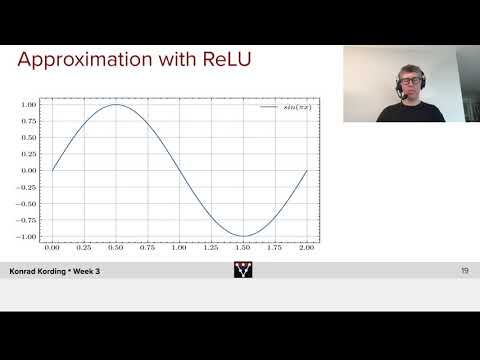

In [ ]:
#@title Video: Universal Approximation

video = YouTubeVideo(id="XXXYxolMVdw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Check out [Lipschitz continuity](https://en.wikipedia.org/wiki/Lipschitz_continuity) for more information about the slide.

So now that we saw multilayer perceptrons could solve the XOR problem. Building off this experiment, a natural question that comes to mind is - can we approximate any function using multilayer perceptrons?

 Universal Approximation theorem proves that we can! The intuition behind the theorem is that we can approximate any function sufficiently well, given a sufficient number of basis functions. These basis functions are present in the hidden layer of MLPs.  

## Exercise 3: Function approximation with ReLU
We learned that one hidden layer MLPs are enough to approximate any smooth function! Now let's manually fit a Sine function using ReLU activation. 


Instead of combining ReLUs with different slopes, we will approximate the sine function using a linear combination (a weighted sum) of ReLUs with slope 1. We need to determine the bias terms (which determines where the ReLU inflection point from 0 to linear occurs) and how to weight each ReLU. The idea is to set the weights iteratively so that the slope changes in the new sample's direction.

First, we generate our "training data" from a sine function. These are the points we will use to learn how to approximate the function. We have 10 training data points so we will have 9 ReLUs (we don't need a ReLU for the last data point as we don't have anything to the right of it to model). 

We first need to figure out the bias term for each ReLU and compute the activation of each ReLU where:

$$ y(x) = max(0, x + b) $$

We then need to figure out the correct weights on each ReLU so the linear combination approximates the desired function.

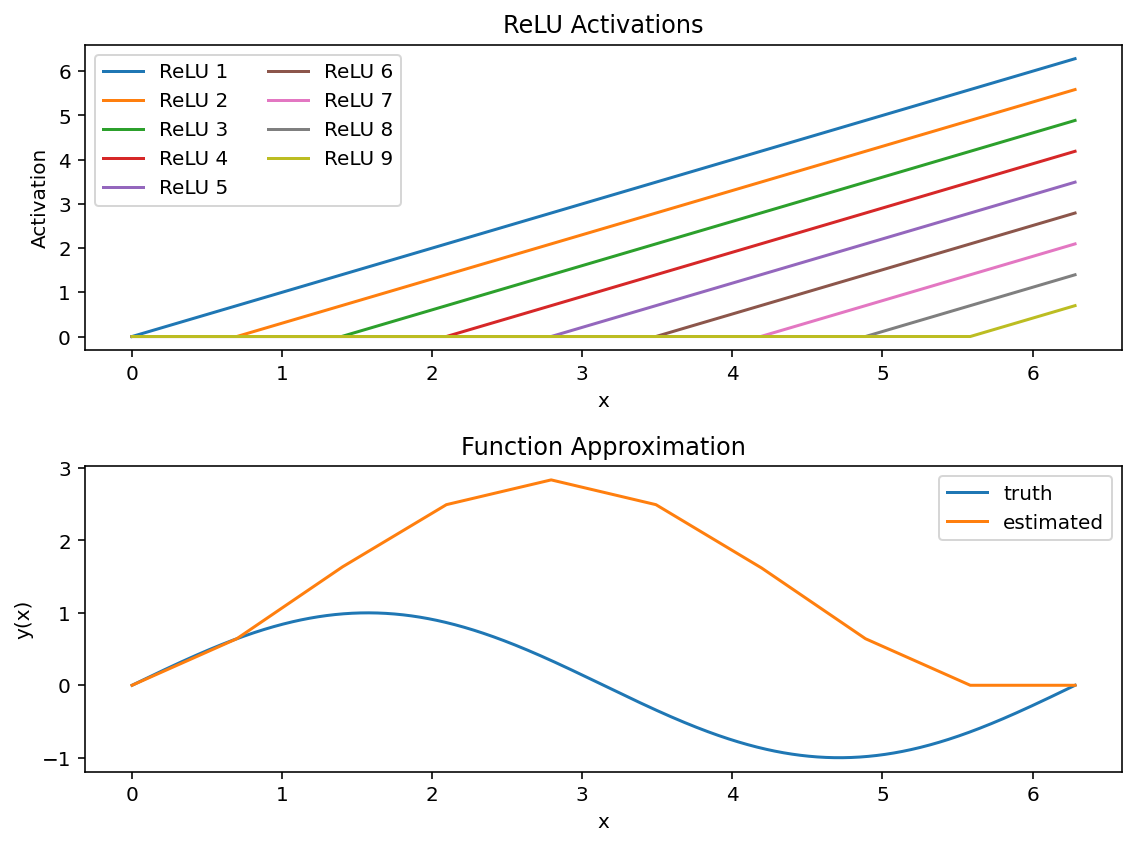

In [ ]:
def approximate_function(x_train, y_train):

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Complete approximate_function!")
    ####################################################################

    # Number of relus
    n_relus = x_train.shape[0] - 1

    # x axis points (more than x train)
    x = torch.linspace(torch.min(x_train), torch.max(x_train), 1000)

    ## COMPUTE RELU ACTIVATIONS

    # First determine what bias terms should be for each of 9 ReLUs
    b = -x_train[:-1]

    # Compute ReLU activations for each point along the x axis (x)
    relu_acts = torch.zeros((n_relus, x.shape[0]))

    for i_relu in range(n_relus):
      relu_acts[i_relu, :] = torch.relu(x + b[i_relu])

    ## COMBINE RELU ACTIVATIONS

    # Set up weights for weighted sum of ReLUs
    combination_weights = torch.zeros((n_relus, ))

    # Figure out weights on each ReLU
    prev_slope = 0
    for i in range(n_relus):
      delta_x = x_train[i+1] - x_train[i]
      slope = (y_train[i+1] - y_train[i]) / delta_x 
      combination_weights[i] = slope - prev_slope
      prev_slope = slope

    # Get output of weighted sum of ReLU activations for every point along x axis
    y_hat = combination_weights @ relu_acts

    return y_hat, relu_acts, x

# Make training data from sine function
N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)


### uncomment the lines below to test your function approximation
y_hat, relu_acts, x = approximate_function(x_train, y_train)
plot_function_approximation(x, relu_acts, y_hat)

---
# Section 3: MLPs in Pytorch

Video available at https://youtube.com/watch?v=bAhrg8Z8_r8


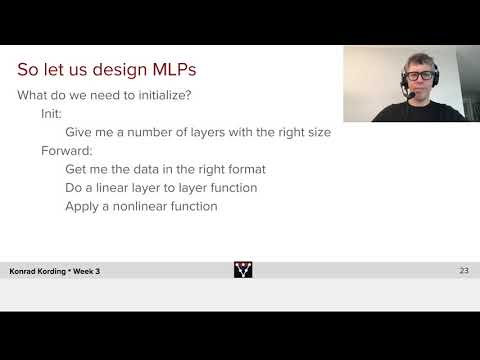

In [ ]:
#@title Video: Making Multi-Layer Perceptrons

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="bAhrg8Z8_r8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In the previous segment, we implemented a function to approximate any smooth function using MLPs. We saw that using Lipschitz continuity; we can prove that our approximation is mathematically correct. MLPs are fascinating, but before we get into the details on designing them, let's familiarize ourselves with some basic terminology of MLPs- layer, neuron, depth, width, weight, bias, and activation function. Armed with these ideas, we can now design an MLP given its input, hidden layers, and output size.

## Exercise 4: Implement a general-purpose MLP in Pytorch
The objective is to design an MLP with these properties:
* works with any input (1D, 2D, etc.)
* construct any number of given hidden layers using ModuleList
* use the same given activation function in all hidden layers

In [ ]:
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        # Assign activation function (exec allows us to assign function from string)
        exec('self.actv = nn.%s'%actv)  

        # Initialize layers of MLP
        self.layers = nn.ModuleList()

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Create MLP Layers")
        ####################################################################

        # Loop over layers and create each one
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs )]
          num_inputs = next_num_inputs

        # Create final layer
        self.out = nn.Linear(num_inputs, num_outputs)

    def forward(self, x: torch.Tensor):

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Calculate the forward pass")
        ####################################################################

        # Flatten inputs to 2D (if more than that)
        x = x.flatten(1, )

        # Get activations of each layer
        for layer in self.layers:
          x = self.actv(layer(x))

        # Get outputs
        x = self.out(x) 

        return x

### Uncomment below to create network and test it on input
net = Net(actv='LeakyReLU(0.1)',
    num_inputs = 16,
    hidden_units = [100, 10, 5],
    num_outputs = 1)

input = torch.zeros((100, 2, 8))
y = net(input)
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2, 8])


## Section 3.2: ReLU in practice


Video available at https://youtube.com/watch?v=E8c1my2S4E8


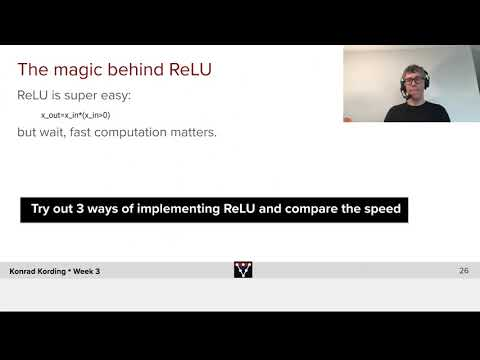

In [ ]:
#@title Video: Implementing ReLU

video = YouTubeVideo(id="E8c1my2S4E8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 5: Benchmark various ReLU implementations
Implement and benchmark at least three different ReLU implementations. Use `%timeit` with test number 10 and repeat number 3. Which then takes an average of 10 runs and repeats 3 times, and reports the lowest (best) average time.


In [ ]:
x = torch.rand((10000, 10000)).to(dev) - 0.5
print("Pytorch : ", end='')
%timeit -n10 -r3 torch.relu(x)
print('-----------------------------------------------')

print("First: ", end='')
%timeit -n10 -r3 x * (x > 0)
print('-----------------------------------------------')

print("Second: ", end='')
%timeit -n10 -r3 torch.where(x > 0, x, torch.zeros_like(x))
print('-----------------------------------------------')

print("Third: ", end='')
%timeit -n10 -r3 torch.maximum(torch.zeros_like(x), x)
print('-----------------------------------------------')

Pytorch : 44.8 ms ± 4.66 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
-----------------------------------------------
First: 172 ms ± 6.83 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
-----------------------------------------------
Second: 370 ms ± 6.83 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
-----------------------------------------------
Third: 93.4 ms ± 1.09 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
-----------------------------------------------


## Section 3.3: Classification with MLPs

Video available at https://youtube.com/watch?v=bxzDe2pifKU


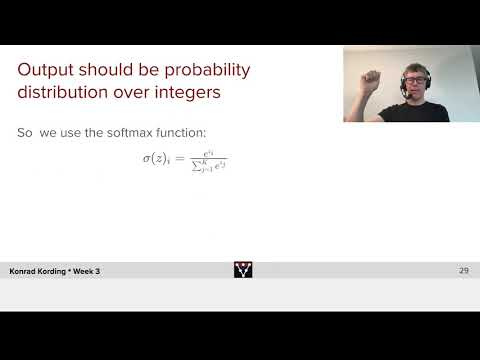

In [ ]:
#@title Video: Classification and CrossEntropy

video = YouTubeVideo(id="bxzDe2pifKU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Two potential loss functions we could use out of the box for multi-class classification are:
* CrossEntropyLoss:
This criterion expects a class index in the range $[0, C-1]$ as the target for each value of a $1D$ tensor of size minibatch. There are other optional parameters like class weights and class ignores. Check the documentation here for more detail. Then in the simplest case, it calculates this,

$$
\operatorname{loss}(x, \text { class })=-\log \left(\frac{\exp (x[\text { class }])}{\sum_{j} \exp (x[j])}\right)=-x[\text { class }]+\log \left(\sum_{j} \exp (x[j])\right)
$$

* MultiMarginLoss:
The loss corresponding to class j is calculated as follows,
$$
l_j(x, y)=\sum_{j\neq y} \max (0, \operatorname{margin}-x[y]+x[j])
$$
Then it is averaged over all the class elements and all the mini-batch samples.

Before we could start optimizing these loss functions, we need a dataset!

## Exercise 6: Simulate a Spiral classification dataset
Let's turn this fancy-looking equation into a classification dataset

$$
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma^{2}\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma^{2}\right) 
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
$$

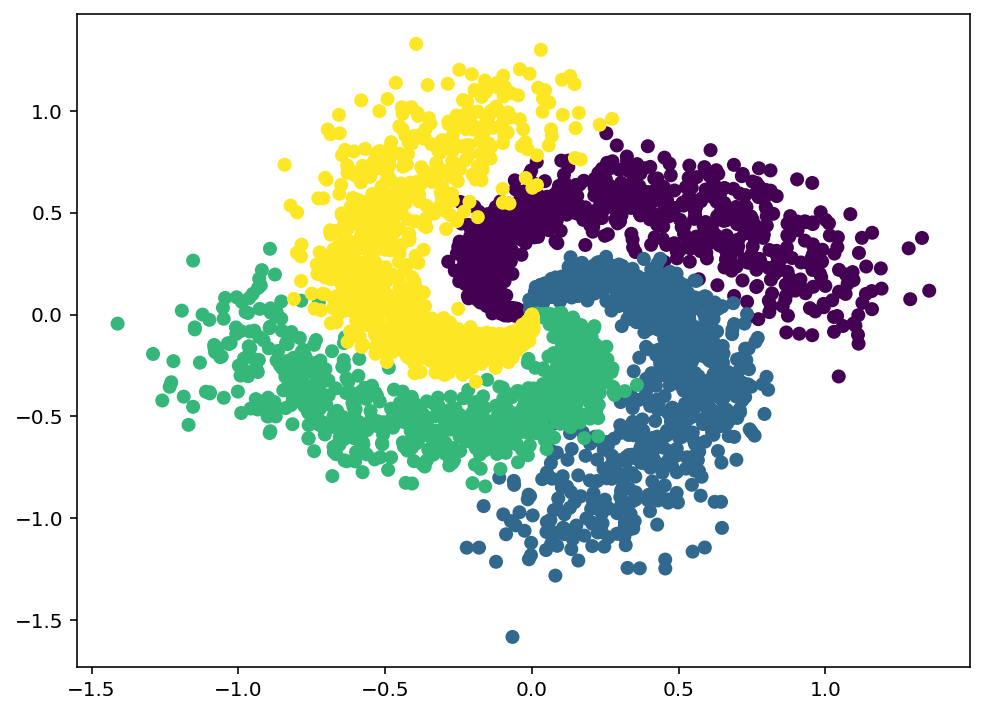

In [ ]:
def create_spiral_dataset(K, sigma, N):

    # Initialize t, X, y
    t = torch.linspace(0, 1, N)
    X = torch.zeros(K*N, 2)
    y = torch.zeros(K*N)

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Create spiral data")
    ####################################################################

    # Create data
    for k in range(K):
      X[k*N:(k+1)*N, 0] = t*(torch.sin(2 * np.pi / K * (2 * t + k - 1)) + sigma * torch.randn(N))
      X[k*N:(k+1)*N, 1] = t*(torch.cos(2 * np.pi / K * (2 * t + k - 1)) + sigma * torch.randn(N))
      y[k*N:(k+1)*N] = k

    return X, y

# Set parameters
K = 4
sigma = 0.16
N = 1000
 
### Uncomment below to visualize data when done
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)

## Section 3.4: Training and Evaluation

Video available at https://youtube.com/watch?v=U6BFrVCLsWU


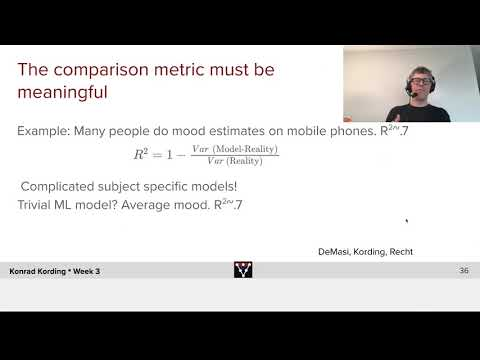

In [ ]:
#@title Video: Cross-Validation

video = YouTubeVideo(id="U6BFrVCLsWU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 7: Implement it for a classfication task
Steps to follow: 
  * Dataset shuffle
  * Train/Test split
  * Dataloader definition
  * Training and Evaluation

Text(0.5, 1.0, 'Test data')

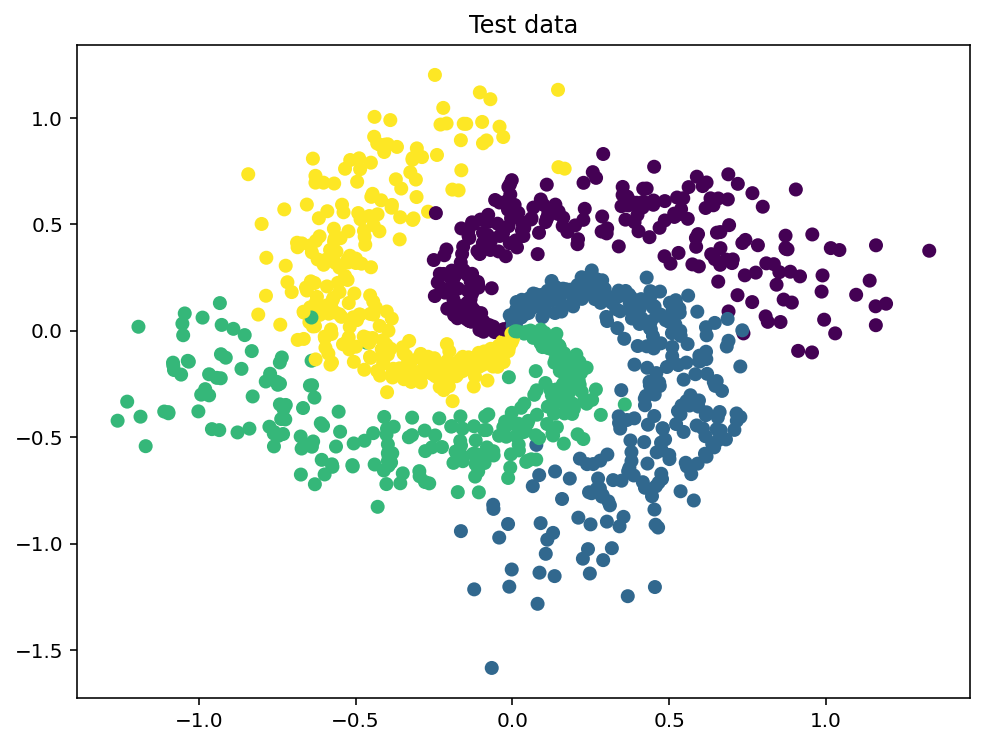

In [ ]:
def shuffle_and_split_data(X, y):

  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Shuffle & split data")
  ####################################################################

  # Number of samples
  N = X.shape[0]

  # Shuffle data
  shuffled_indices = np.random.choice(N, size=N, replace=False)  # get indices to shuffle data
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(.3 * N)  # assign size of test data
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


### Uncomment below to test your function
X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test data')

And we need to make a Pytorch data loader out of it. Data loading in PyTorch can be separated in 2 parts:
* Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Not that at this point the data is not loaded on memory. PyTorch will only load what is needed to the memory. Here `TensorDataset` does this for us directly.
* Use a Dataloader that will actually read the data in batches and put into memory. Also, the option of `num_workers > 0` allows multithreading, which prepares multiple batches in the queue to speed things up.

In [ ]:
batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=0, worker_init_fn=seed_worker)

Let's write a general-purpose training and evaluation code and keep it in our pocket for next tutorial as well. So make sure you review it to see what it does.

Note that `model.train()` tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. And to turn off training mode we set `model.eval()`

In [ ]:
def train_test_classification(net, criterion, optimizer,
                              train_loader, test_loader,
                              num_epochs=1, verbose=True, 
                              training_plot=False):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()
  training_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0

  net.eval()
  def test(data_loader):
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(dev).float()
        labels = labels.to(dev).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))
    print('Accuracy on the %d testing samples: %0.2f %%' % (test_total, test_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc, test_acc

Now let's put everything together and train your first deep-ish model!

Accuracy on the 2688 training samples: 98.96 %
Accuracy on the 1200 testing samples: 98.67 %


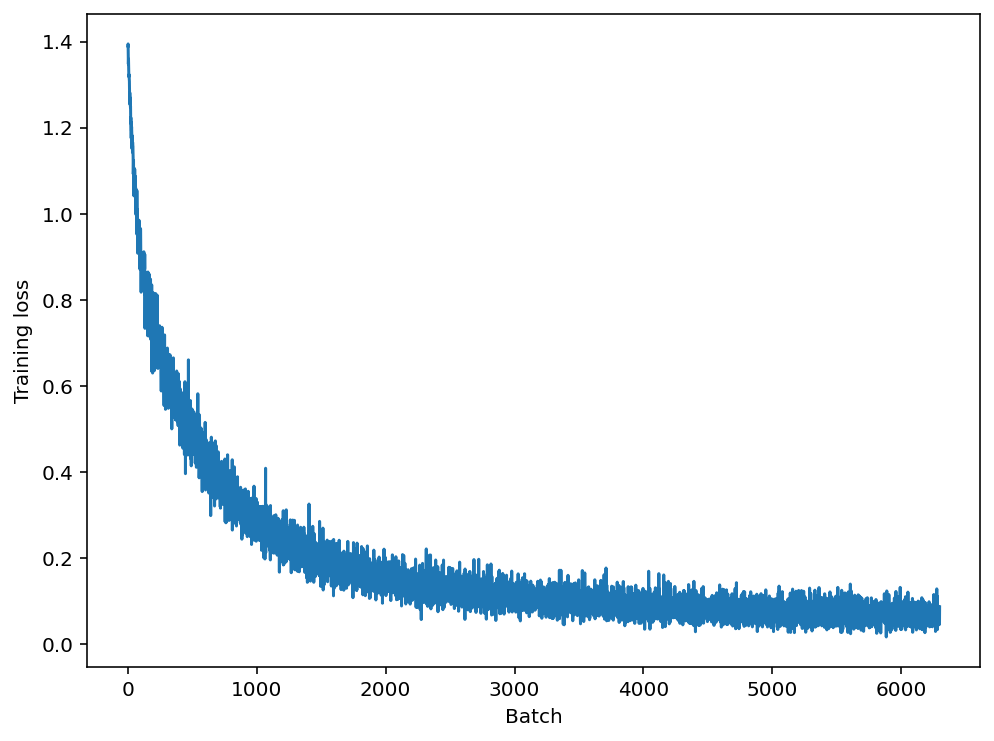

In [ ]:
net = Net('ReLU()', X_train.shape[1], [128,], K).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 300
_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True)

And finally, let's visualize the learned decision-map. We know you're probably running out of time, so we won't make you write code now! But make sure you have reviewed it since we'll start with another visualization technique next time.

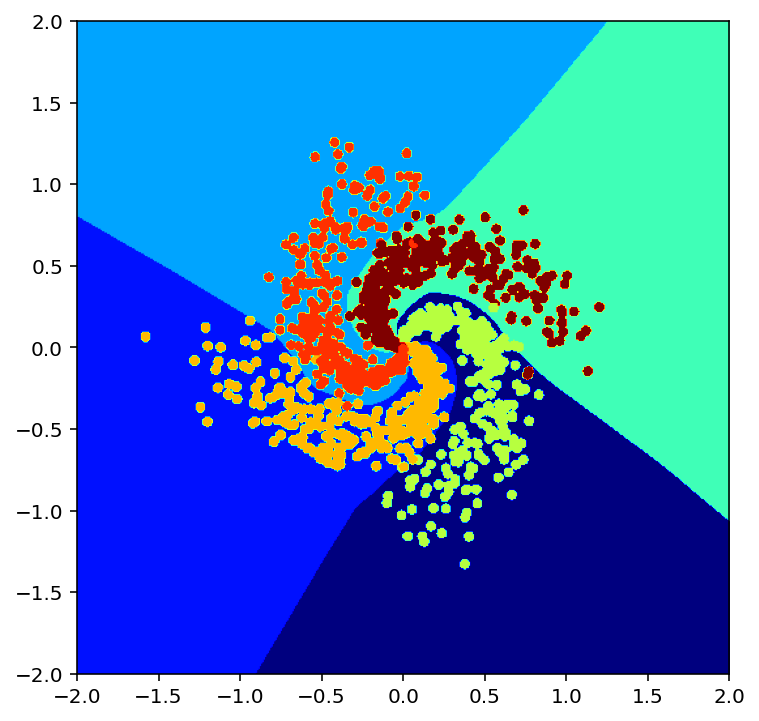

In [ ]:
def sample_grid(M=500, x_max = 2.0):
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all

def plot_decision_map(X_all, y_pred, X_test, y_test, M=500, x_max = 2.0, eps = 1e-3):
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.plot()

X_all = sample_grid()
y_pred = net(X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)

# Quiz

In [ ]:
#@markdown Why do you think increasing the membrane resistance leads to a more ReLU like transfer function in Section 1.2.?
why_become_relu = 'it makes the V/R term small, which leaves a linear I/C term. Delays reaching threshold ' #@param {type:"string"}

In [ ]:
#@markdown Is it necessary to use `net.train()` and `net.eval()` for our MLP model in Exercise 7? Why?
why_two_modes = 'Yes so that pytorch knows to apply things like a dropout and batchnorm when training, and to disable gradient tracking when evaluating' #@param {type:"string"}

In [ ]:
#@markdown Do you think the model in Exercise 7 is performing well outside its training distribution? Why?
out_of_distr = 'yes, assuming future test data is spiraly, because the decision boundaries are regular, so it should generalize well to more spiraly data' #@param {type:"string"}

In [ ]:
#@markdown Why is the XOR problem exceptionally interesting to neural network researchers?
xor_interesting = 'because it is compact and non-linear' #@param {type:"string"}

# Submit your responses
Please run the following cell and then press "Submit" so we can record your responses.

In [ ]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()

try: t1;
except NameError: t1 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: my_email;
except NameError: my_pod = "Select"

try: wwhy_become_relu;
except NameError: why_become_relu = ""

try: why_two_modes;
except NameError: why_two_modes = ""

try: out_of_distr;
except NameError: out_of_distr = ""

try: xor_interesting;
except NameError: xor_interesting = ""

times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "email": my_email,
          "why_become_relu": why_become_relu,
          "why_two_modes": why_two_modes,
          "out_of_distr": out_of_distr,
          "xor_interesting": xor_interesting,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrUv9g9UReJzgxgS?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?


In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))